In [1]:
from keras.datasets import cifar10
from keras.engine import training
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Activation, add, Dense, Flatten, AveragePooling2D, BatchNormalization, Concatenate
from keras.models import Model, Sequential, Input
from keras.optimizers.schedules import ExponentialDecay
from keras.callbacks import History, ModelCheckpoint, EarlyStopping, LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy

import os
import numpy as np
import matplotlib.pyplot as plt


In [2]:
lr_schedule = ExponentialDecay(initial_learning_rate=1e-4,
                               decay_steps=10000,
                               decay_rate=0.8)

In [3]:
# https://towardsdatascience.com/ensembling-convnets-using-keras-237d429157eb

def conv_pool_cnn(model_input) -> training.Model:

    x = Conv2D(96, kernel_size=(3, 3), activation='relu',
               padding='same')(model_input)
    x = Dropout(0.1)(x)
    x = Conv2D(96, (3, 3), activation='relu', padding='same')(x)
    x = Dropout(0.1)(x)
    x = Conv2D(96, (3, 3), activation='relu', padding='same')(x)
    x = Dropout(0.1)(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=2)(x)
    x = Conv2D(192, (3, 3), activation='relu', padding='same')(x)
    x = Dropout(0.1)(x)
    x = Conv2D(192, (3, 3), activation='relu', padding='same')(x)
    x = Dropout(0.1)(x)
    x = Conv2D(192, (3, 3), activation='relu', padding='same')(x)
    x = Dropout(0.1)(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=2)(x)
    x = Conv2D(192, (3, 3), activation='relu', padding='same')(x)
    x = Dropout(0.1)(x)
    x = Conv2D(192, (1, 1), activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Conv2D(10, (1, 1))(x)
    x = GlobalAveragePooling2D()(x)
    x = Activation(activation='softmax')(x)

    model = Model(model_input, x, name='conv_pool_cnn')

    return model

In [4]:
save_dir = os.path.join(os.getcwd(), 'drive', 'MyDrive', 'saved_models')

In [5]:
def compile_and_train(model: training.Model, 
                      num_epochs: int, 
                      x_train, 
                      y_train, 
                      x_test, 
                      y_test, 
                      batch_size=32,
                      optimizer=None, 
                      extra_callbacks=None):
    if optimizer is None:
        optimizer = Adam()

    model.compile(loss=categorical_crossentropy,
                  optimizer=optimizer, metrics=['acc'])
    
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
        
    filename = model_name + model.name + '.h5'
    model_path = os.path.join(save_dir, filename)
    early_stop = EarlyStopping(monitor='val_loss', patience=50)
    checkpoint = ModelCheckpoint(
        filepath=model_path, monitor='val_loss', save_best_only=True)

    callbacks = [early_stop, checkpoint]

    if (extra_callbacks is not None):
        callbacks = callbacks + extra_callbacks

    data_generated = ImageDataGenerator(horizontal_flip=True,
                                        width_shift_range=0.125,
                                        height_shift_range=0.125,
                                        fill_mode='constant',
                                        cval=0.,
                                        rotation_range=20)

    data_generated.fit(x_train)
    train_generator = data_generated.flow(x_train,
                                         y_train,
                                         batch_size=32)

    val_data_generated = ImageDataGenerator(horizontal_flip=True,
                                            width_shift_range=0.125,
                                            height_shift_range=0.125,
                                            fill_mode='constant',
                                            cval=0.,
                                            rotation_range=20)

    val_generator = val_data_generated.flow(x_test,
                                            y_test,
                                            batch_size=batch_size)
    
    train_steps_per_epoch = x_train.shape[0] // batch_size
    val_steps_per_epoch = x_test.shape[0] // batch_size

    history = model.fit(train_generator,
                        steps_per_epoch=train_steps_per_epoch,
                        epochs=num_epochs, 
                        verbose=1, 
                        callbacks=callbacks, 
                        validation_data=val_generator,
                        validation_steps=val_steps_per_epoch)
    return history, model_path

In [6]:
def compile_and_train_2(model: training.Model, 
                        num_epochs: int, 
                        x_train, 
                        y_train, 
                        x_test, 
                        y_test, 
                        batch_size=32, 
                        optimizer=None, 
                        extra_callbacks=None):
    if optimizer is None:
        optimizer = Adam()

    model.compile(loss=categorical_crossentropy,
                  optimizer=optimizer, metrics=['acc'])
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    filename = model_name + model.name + '.h5'
    model_path = os.path.join(save_dir, filename)
    early_stop = EarlyStopping(monitor='val_loss', patience=50)
    checkpoint = ModelCheckpoint(
        filepath=model_path, monitor='val_loss', save_best_only=True)

    callbacks = [early_stop, checkpoint]

    if (extra_callbacks is not None):
        callbacks = callbacks + extra_callbacks

    datagen = ImageDataGenerator(horizontal_flip=True,
                                 width_shift_range=0.125,
                                 height_shift_range=0.125,
                                 fill_mode='constant',
                                 cval=0.,
                                 rotation_range=20)

    datagen.fit(x_train)

    history = model.fit_generator(datagen.flow(x_train, y_train,
                                               batch_size=batch_size),
                                  epochs=num_epochs, 
                                  verbose=1, 
                                  callbacks=callbacks, 
                                  validation_data=(x_test, y_test))
    return history, model_path

In [7]:
def load_data_keras() -> (np.ndarray, np.ndarray,
                          np.ndarray, np.ndarray):
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    x_train = x_train / 255.
    x_test = x_test / 255.
    y_train = to_categorical(y_train, num_classes=10)
    y_test = to_categorical(y_test, num_classes=10)
    return x_train, y_train, x_test, y_test

In [8]:
x_train, y_train, x_test, y_test = load_data_keras()

170500096/170498071 [==============================] - 4s 0us/step


In [9]:
y_train.shape

(50000, 10)

In [10]:
input_shape = (32, 32, 3)
model_input = Input(shape=input_shape)

In [11]:
conv_pool_cnn_model = conv_pool_cnn(model_input)

In [12]:
model_name = 'keras_cifar10_conv_pool'
num_classes = 10
epochs = 100
batch_size = 128

In [13]:
history_conv, conv_pool_cnn_file = compile_and_train_2(conv_pool_cnn_model, 
                                                     epochs, 
                                                     x_train, 
                                                     y_train, 
                                                     x_test, 
                                                     y_test, 
                                                     batch_size)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
391/391 [==============================] - 66s 84ms/step - loss: 2.0674 - acc: 0.1922 - val_loss: 1.6853 - val_acc: 0.3518
Epoch 2/100
391/391 [==============================] - 32s 81ms/step - loss: 1.5787 - acc: 0.4093 - val_loss: 1.3062 - val_acc: 0.5269
Epoch 3/100
391/391 [==============================] - 32s 81ms/step - loss: 1.3096 - acc: 0.5212 - val_loss: 1.1995 - val_acc: 0.5791
Epoch 4/100
391/391 [==============================] - 32s 82ms/step - loss: 1.1075 - acc: 0.5975 - val_loss: 1.0138 - val_acc: 0.6420
Epoch 5/100
391/391 [==============================] - 32s 81ms/step - loss: 0.9991 - acc: 0.6424 - val_loss: 0.9162 - val_acc: 0.6793
Epoch 6/100
391/391 [==============================] - 32s 81ms/step - loss: 0.8938 - acc: 0.6848 - val_loss: 0.8740 - val_acc: 0.7023
Epoch 7/100
391/391 [==============================] - 32s 81ms/step - loss: 0.8343 - acc: 0.7061 - val_loss: 0.7606 - val_acc: 0.7404
Epoch 8/100
391/391 [==============================] - 

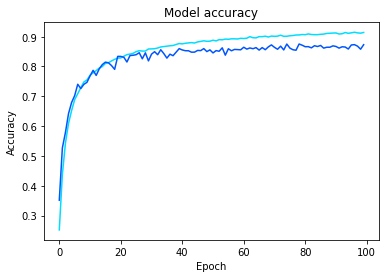

In [18]:
plt.plot(history_conv.history['acc'], color='#00ddff')
plt.plot(history_conv.history['val_acc'], color='#0055ff')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()